In [3]:
%pylab inline
#from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Calculate integer dimensions for numpy "image" matrix
# used to represent gene expression data from text file
# NOTE: the last 3 gene expression values are dropped from
# each sample to achieve an integer dimension for the matrix
# TODO: add 0-padding to avoid dropping the last 3 values
height = 225
width = 64800 / height
print(height, width)

225 288.0


In [5]:
# This version takes the input dims as an arg
# and calculates the total features output from the last conv2d
# layer for sizing the first fully-connected layer
class MyConv2DNet(nn.Module):
    def __init__(self, inshape=(1,224,270)):
        super(MyConv2DNet, self).__init__()
        # 1 input channel for FPKM values, 12 filters, 3x3 conv
        self.conv1 = nn.Conv2d(1, 12, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(12, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.convdrop1 = nn.Dropout2d(p=0.3)
        
        conv_out_feats = self._get_conv_outshape(inshape)
        
        self.fc1 = nn.Linear(conv_out_feats, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 13) # 13 classes for cancer types represented in train/valid data
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.fc2(x))
        #x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:] # all dims except batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def _conv_forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        return x

    def _get_conv_outshape(self, inshape):
        batchsz = 1
        dummy_input = Variable(torch.rand(batchsz, *inshape))
        dummy_output = self._conv_forward(dummy_input)
        feature_cnt = dummy_output.data.view(batchsz, -1).size(1)
        return feature_cnt

In [6]:
# Create a dataset class for the gene-fpkm values data (based on pytorch data processing tutorial:
# pytorch.org/tutorials/beginner/data_loading_tutorial.html)

# This version normalizes fpkm values from 0 to 255 (for single channel "image" representation)

class GeneExpressionFPKMDatasetN1(Dataset):
    """Gene expression RNAseq FPKM values dataset."""
    def __init__(self, samplenames_file, data_dir, transform=None):
        self.filename_frame = pd.read_csv((os.path.join(data_dir, samplenames_file)),
                                           sep="\s+", names=["filename","label"],
                                          dtype={'filename':'object', 'label':'category'})
        self.root_dir = data_dir
        # 180518 store original class names from manifest file
        self.class_encoder = LabelEncoder().fit(self.filename_frame.label)
        #self.labels = self.labelstrs.factorize(sort=True)[0]
        self.transform = transform
    
    def __len__(self):
        return len(self.filename_frame)
    
    def __getitem__(self, idx):
        sample_name = os.path.join(self.root_dir, self.filename_frame.iloc[idx, 0])
        label = self.class_encoder.transform([self.filename_frame.iloc[idx, 1]])
        #label = np.array([self.labels[idx]])
        pxdf = pd.read_csv(sample_name, sep='\s+', header=None, names=['fpkm'])
        #pxdf['normval'] = pxdf.fpkm.apply(lambda x: floor(255 if x == 1.0 else x * 256.0))
        pxdf['normval'] = (pxdf.fpkm - pxdf.fpkm.mean()) / pxdf.fpkm.std() 
        fpkmvals = pxdf.normval.astype(np.float32).values
        fpkmvals = fpkmvals[3:] # drop first 3 vals to keep shape
        
        # NOTE: no transforms for now (values are not loaded with torchvision)
        # torch image: C X H X W
        fpkmvals = fpkmvals.reshape((1, 224, 270))
        fpkmvals = torch.from_numpy(fpkmvals)
        label = torch.from_numpy(label)
        
        return {'fpkmvals': fpkmvals.type(torch.FloatTensor),
                'label': label.type(torch.LongTensor)}
    

In [7]:
# shuffle manifest file to try to ensure both classes represented in any given training batch
testdata = GeneExpressionFPKMDatasetN1("test_manifest.txt", "/ssdata/data/tcga/fpkm13class/test/")
traindata = GeneExpressionFPKMDatasetN1("train_manifest.txt", "/ssdata/data/tcga/fpkm13class/train/")
validdata = GeneExpressionFPKMDatasetN1("valid_manifest.txt", "/ssdata/data/tcga/fpkm13class/valid/")

testloader = DataLoader(testdata, batch_size=8, shuffle=True, num_workers=4)
trainloader = DataLoader(traindata, batch_size=8, shuffle=True, num_workers=4)
validloader = DataLoader(validdata, batch_size=8, shuffle=False, num_workers=4)

In [8]:
# wrapper functions for net initialization, training runs, and quick accuracy check
# TODO: create cross-validation procedure and work on visualization of loss during training

def newNetCuda(model):
    net = model()
    net.training = True
    net.cuda()
    net.zero_grad()
    return net

    
def trainRun(model, epochs=10, lr=1.0e-3):
    net.training = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, eps=1e-6)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs = data['fpkmvals']
            labels = data['label']
            inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
            labels = labels.squeeze() # must be Tensor of dim BATCH_SIZE, MUST BE 1Dimensional!
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # running stats
            running_loss += loss.data[0]
            if i % 8 == 7:
                print("[%d, %5d] loss: %.4f" %
                      (epoch + 1, i + 1, running_loss / 8))
                running_loss = 0.0
            
    print("Finished")
    
def checkAccuracy(model, tloader, vloader):
    net = model
    net.training = False
    trainloader = tloader
    validloader = vloader
    class_correctT = list(0. for i in range(13))
    class_totalT = list(0. for i in range(13))
    classes = ("BRCA","COAD","GBM","HNSC","KIRC","KIRP","LGG","LUAD","LUSC",
               "PRAD","READ","THCA","UCEC")
    for data in trainloader:
        imagesT, labelsT = data['fpkmvals'], data['label']
        outputsT = net(Variable(imagesT).cuda())
        _, predicted = torch.max(outputsT.data, 1)
        c = (predicted.cpu() == labelsT.squeeze()).numpy()
        for i in range(len(labelsT)):
            label = int(labelsT[i][0])
            class_correctT[label] += c[i]
            class_totalT[label] += 1
    print("Training set accuracy: ")    
    for i in range(len(classes)):
        print("Accuracy of %5s: %2d%%" % (classes[i], 100 * class_correctT[i] / class_totalT[i]))
    
    class_correctV = list(0. for i in range(13))
    class_totalV = list(0. for i in range(13))
    for data in validloader:
        imagesV, labelsV = data['fpkmvals'], data['label']
        outputsV = net(Variable(imagesV).cuda())
        _, predicted = torch.max(outputsV.data, 1)
        c = (predicted.cpu() == labelsV.squeeze()).numpy()
        for i in range(len(labelsV)):
            label = int(labelsV[i][0])
            class_correctV[label] += c[i]
            class_totalV[label] += 1
    print("Validation set accuracy: ") 
    for i in range(len(classes)):
        print("Accuracy of %5s: %2d%%" % (classes[i], 100 * class_correctV[i] / class_totalV[i]))

In [129]:
net = newNetCuda(model=MyConv2DNet)
%time trainRun(net, epochs=2)

[1,     8] loss: 3.2833
[1,    16] loss: 2.4017
[1,    24] loss: 2.3748
[1,    32] loss: 2.3556
[1,    40] loss: 2.3391
[1,    48] loss: 2.2472
[1,    56] loss: 2.2995
[1,    64] loss: 2.2185
[1,    72] loss: 1.6702
[1,    80] loss: 2.0554
[1,    88] loss: 1.7738
[1,    96] loss: 1.7982
[1,   104] loss: 1.6054
[1,   112] loss: 1.5287
[1,   120] loss: 1.8138
[1,   128] loss: 1.8698
[1,   136] loss: 1.2341
[1,   144] loss: 1.5530
[1,   152] loss: 1.5774
[1,   160] loss: 1.3712
[1,   168] loss: 1.4780
[1,   176] loss: 1.2406
[1,   184] loss: 1.0653
[1,   192] loss: 1.4540
[1,   200] loss: 1.2252
[1,   208] loss: 1.0775
[1,   216] loss: 1.3754
[1,   224] loss: 0.8953
[1,   232] loss: 1.5754
[1,   240] loss: 1.2022
[1,   248] loss: 1.0070
[1,   256] loss: 1.0558
[1,   264] loss: 1.1291
[1,   272] loss: 0.9117
[1,   280] loss: 0.9309
[1,   288] loss: 1.1729
[1,   296] loss: 1.1357
[1,   304] loss: 1.1468
[1,   312] loss: 1.1349
[1,   320] loss: 1.1331
[1,   328] loss: 1.0935
[1,   336] loss:

In [130]:
checkAccuracy(net, trainloader, validloader)

Training set accuracy: 
Accuracy of  BRCA: 99%
Accuracy of  COAD: 98%
Accuracy of   GBM: 81%
Accuracy of  HNSC: 94%
Accuracy of  KIRC: 85%
Accuracy of  KIRP: 94%
Accuracy of   LGG: 98%
Accuracy of  LUAD: 83%
Accuracy of  LUSC: 89%
Accuracy of  PRAD: 98%
Accuracy of  READ:  0%
Accuracy of  THCA: 99%
Accuracy of  UCEC: 93%
Validation set accuracy: 
Accuracy of  BRCA: 98%
Accuracy of  COAD: 100%
Accuracy of   GBM: 100%
Accuracy of  HNSC: 90%
Accuracy of  KIRC: 85%
Accuracy of  KIRP: 95%
Accuracy of   LGG: 93%
Accuracy of  LUAD: 67%
Accuracy of  LUSC: 78%
Accuracy of  PRAD: 100%
Accuracy of  READ:  0%
Accuracy of  THCA: 100%
Accuracy of  UCEC: 84%


In [10]:
%time trainRun(net, epochs=7)

[1,     8] loss: 0.3739
[1,    16] loss: 0.3289
[1,    24] loss: 0.5001
[1,    32] loss: 0.5046
[1,    40] loss: 0.4178
[1,    48] loss: 0.4871
[1,    56] loss: 0.6646
[1,    64] loss: 0.5542
[1,    72] loss: 0.3801
[1,    80] loss: 0.3853
[1,    88] loss: 0.2009
[1,    96] loss: 0.5450
[1,   104] loss: 0.3825
[1,   112] loss: 0.5381
[1,   120] loss: 0.4720
[1,   128] loss: 0.4223
[1,   136] loss: 0.2920
[1,   144] loss: 0.3814
[1,   152] loss: 0.5882
[1,   160] loss: 0.5881
[1,   168] loss: 0.2842
[1,   176] loss: 0.4630
[1,   184] loss: 0.4509
[1,   192] loss: 0.3327
[1,   200] loss: 0.3658
[1,   208] loss: 0.5523
[1,   216] loss: 0.4592
[1,   224] loss: 0.4303
[1,   232] loss: 0.3617
[1,   240] loss: 0.4880
[1,   248] loss: 0.3932
[1,   256] loss: 0.2802
[1,   264] loss: 0.4423
[1,   272] loss: 0.3278
[1,   280] loss: 0.3437
[1,   288] loss: 0.3680
[1,   296] loss: 0.5083
[1,   304] loss: 0.3781
[1,   312] loss: 0.2145
[1,   320] loss: 0.5688
[1,   328] loss: 0.4237
[1,   336] loss:

In [11]:
checkAccuracy(net, trainloader, validloader)

Training set accuracy: 
Accuracy of  BRCA: 100%
Accuracy of  COAD: 100%
Accuracy of   GBM: 100%
Accuracy of  HNSC: 96%
Accuracy of  KIRC: 98%
Accuracy of  KIRP: 96%
Accuracy of   LGG: 100%
Accuracy of  LUAD: 99%
Accuracy of  LUSC: 89%
Accuracy of  PRAD: 100%
Accuracy of  READ:  0%
Accuracy of  THCA: 100%
Accuracy of  UCEC: 100%
Validation set accuracy: 
Accuracy of  BRCA: 98%
Accuracy of  COAD: 100%
Accuracy of   GBM: 100%
Accuracy of  HNSC: 83%
Accuracy of  KIRC: 92%
Accuracy of  KIRP: 90%
Accuracy of   LGG: 93%
Accuracy of  LUAD: 89%
Accuracy of  LUSC: 71%
Accuracy of  PRAD: 100%
Accuracy of  READ:  0%
Accuracy of  THCA: 97%
Accuracy of  UCEC: 97%


In [12]:
from sklearn.metrics import confusion_matrix

In [17]:
#net = newNetCuda(model=Net3)
trainRun(net, epochs=10, lr=1.0e-3)

[1,     8] loss: 0.1032
[1,    16] loss: 0.3389
[1,    24] loss: 0.1226
[1,    32] loss: 0.2883
[1,    40] loss: 0.0695
[1,    48] loss: 0.1461
[1,    56] loss: 0.1214
[1,    64] loss: 0.1479
[1,    72] loss: 0.1837
[1,    80] loss: 0.1787
[1,    88] loss: 0.1068
[1,    96] loss: 0.2188
[1,   104] loss: 0.1839
[1,   112] loss: 0.1377
[1,   120] loss: 0.1528
[1,   128] loss: 0.2050
[1,   136] loss: 0.3564
[1,   144] loss: 0.1659
[1,   152] loss: 0.2705
[1,   160] loss: 0.2162
[1,   168] loss: 0.2342
[1,   176] loss: 0.2039
[1,   184] loss: 0.4902
[1,   192] loss: 0.2576
[1,   200] loss: 0.2223
[1,   208] loss: 0.2664
[1,   216] loss: 0.2057
[1,   224] loss: 0.3157
[1,   232] loss: 0.2379
[1,   240] loss: 0.2991
[1,   248] loss: 0.1634
[1,   256] loss: 0.1911
[1,   264] loss: 0.2762
[1,   272] loss: 0.1543
[1,   280] loss: 0.1434
[1,   288] loss: 0.2199
[1,   296] loss: 0.1229
[1,   304] loss: 0.1883
[1,   312] loss: 0.1857
[1,   320] loss: 0.1555
[1,   328] loss: 0.2272
[1,   336] loss:

In [11]:
checkAccuracy(net, trainloader, validloader)

Training set accuracy: 
Accuracy of  BRCA: 99%
Accuracy of  COAD: 98%
Accuracy of   GBM: 90%
Accuracy of  HNSC: 95%
Accuracy of  KIRC: 97%
Accuracy of  KIRP: 85%
Accuracy of   LGG: 99%
Accuracy of  LUAD: 96%
Accuracy of  LUSC: 92%
Accuracy of  PRAD: 99%
Accuracy of  READ:  0%
Accuracy of  THCA: 99%
Accuracy of  UCEC: 99%
Validation set accuracy: 
Accuracy of  BRCA: 98%
Accuracy of  COAD: 91%
Accuracy of   GBM: 100%
Accuracy of  HNSC: 90%
Accuracy of  KIRC: 95%
Accuracy of  KIRP: 85%
Accuracy of   LGG: 96%
Accuracy of  LUAD: 89%
Accuracy of  LUSC: 80%
Accuracy of  PRAD: 100%
Accuracy of  READ:  0%
Accuracy of  THCA: 97%
Accuracy of  UCEC: 97%


In [127]:
torch.save(net.state_dict(), "/seq/tcga/predict_ctype/fpkm13class/tcga13class_convnet1_statedict.pth")
#torch.save(net, "/seq/tcga/predict_ctype/lung2class/model2net.pth")

In [114]:
ctypeREADimgs = [d['fpkmvals'] for d in iter(validdata) if d['label'].numpy()[0] == 10]
ctypeBRCAimgs = [d['fpkmvals'] for d in iter(validdata) if d['label'].numpy()[0] == 0]

In [115]:
readimgs = [i.numpy() for i in ctypeREADimgs]
brcaimgs = [i.numpy() for i in ctypeBRCAimgs]

In [71]:
padzeros = np.zeros((224,270))

In [72]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [86]:
def imshow2(img):
    #img = img / 2 + 0.5
    imgarr = np.array([img[0,:,:], img[0,:,:], img[0,:,:]]).transpose(1,2,0)
    plt.imshow(imgarr)

In [118]:
def imshow3(img):
    #img = img / 2 + 0.5
    imgarr = np.array([img[0,:,:], padzeros, padzeros]).transpose(1,2,0)
    plt.imshow(imgarr)

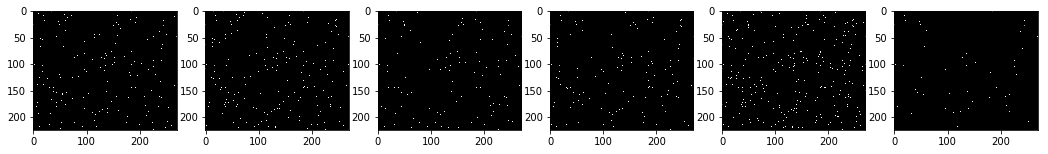

In [116]:
first6 = readimgs[:6]

f, a = plt.subplots(figsize=(18,18))

for (n, i) in enumerate(first6):
    plt.gca()
    plotnum = 160 + (n + 1)
    plt.subplot(plotnum)
    imgarr = np.array([i[0,:,:], i[0,:,:], i[0,:,:]]).transpose(1,2,0)
    plt.imshow(imgarr)
    
    
    
    
    

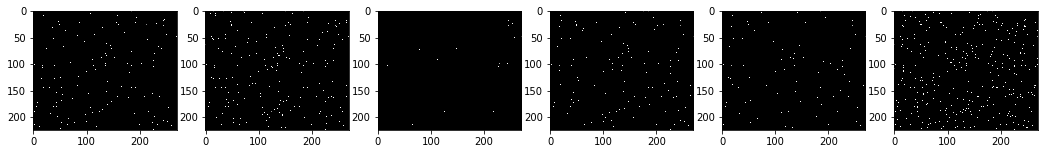

In [117]:
firstbrca6 = brcaimgs[:6]

f, a = plt.subplots(figsize=(18,18))

for (n, i) in enumerate(firstbrca6):
    plt.gca()
    plotnum = 160 + (n + 1)
    plt.subplot(plotnum)
    imgarr = np.array([i[0,:,:], i[0,:,:], i[0,:,:]]).transpose(1,2,0)
    plt.imshow(imgarr)

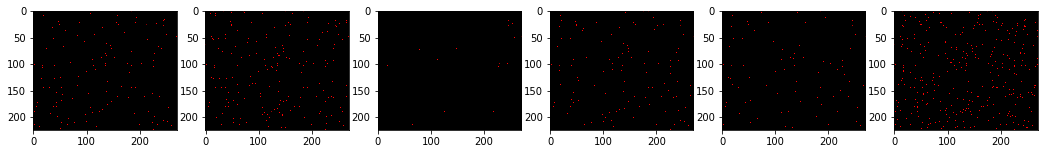

In [125]:
firstbrca6 = brcaimgs[:6]

f, a = plt.subplots(figsize=(18,18))

for (n, i) in enumerate(firstbrca6):
    plt.gca()
    plotnum = 160 + (n + 1)
    plt.subplot(plotnum)
    imgarr = np.array([i[0,:,:], padzeros, padzeros]).transpose(1,2,0)
    plt.imshow(imgarr, interpolation="nearest")

In [16]:
# save fpkm tensors as images to test using image classifier libraries to load and use data
t1 = next(iter(testdata))

In [19]:
type(t1['fpkmvals'])

torch.FloatTensor

In [21]:
imgpath = '/ssdata/data/tcga/fpkm13class/fpkm_as_jpg'

torchvision.utils.save_image(t1['fpkmvals'], imgpath + '/test1.jpg', padding=0)

In [ ]:
# function to save all tensors in dataset as jpg images with 

In [7]:
testdata = GeneExpressionFPKMDatasetN1("test_manifest.txt", "/ssdata/data/tcga/fpkm13class/test/")

In [8]:
t = next(iter(testdata))

In [133]:
testdata.class_encoder.inverse_transform(8)

/home/irish/py36torch03/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'LUSC'

In [11]:
t['fpkmvals'].shape

torch.Size([1, 224, 270])

In [12]:
224 * 270

60480

In [ ]:
self.filename_frame = pd.read_csv((os.path.join(data_dir, samplenames_file)),
                                           sep="\s+", names=["filename","label"],
                                          dtype={'filename':'object', 'label':'category'})
        self.root_dir = data_dir
        #self.labels = pd.get_dummies(self.filename_frame['label']).as_matrix()
        self.labels = self.filename_frame['label'].factorize(sort=True)[0]

In [144]:
def save_dataset_to_jpgs(dataset, img_path=None):
    """Save Dataset instance to jpeg images with class labels as filename prefixes"""
    if img_path is None:
        img_path = dataset.root_dir
    for (i, e) in enumerate(dataset):
        lbl = dataset.class_encoder.inverse_transform(e['label'][0])
        jpg_fname = f'{lbl}_{i}.jpg'
        torchvision.utils.save_image(e['fpkmvals'], os.path.join(img_path, jpg_fname), padding=0)

In [145]:
save_dataset_to_jpgs(testdata, "/ssdata/data/tcga/testjpegs")

In [146]:
# create jpeg files of FPKM values for training and validation sets all in a single folder
# NOTE: validation set will be sampled from the training set when jpeg files are loaded into conv_learner
# dataset

alldata = GeneExpressionFPKMDatasetN1("alldata_manifest.txt",
                                      "/ssdata/data/tcga/fpkm13class/all/")

In [147]:
len(alldata)

4287

In [148]:
%time save_dataset_to_jpgs(alldata, img_path="/ssdata/data/tcga/fpkm13class/all/jpeg")

CPU times: user 2min 8s, sys: 13.1 ms, total: 2min 8s
Wall time: 58.9 s


In [2]:
type(testdata)

NameError: name 'testdata' is not defined